In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen


%matplotlib inline
%matplotlib notebook

In [2]:
#load data
path_to_file = '/mnt/d/data.csv'
df = pd.read_csv(path_to_file)

In [3]:
# set alpha level
alpha = 0.05

In [4]:
#prepare data
def prep_data(df: pd.DataFrame, name: str or list)-> pd.DataFrame:
    if type(name) == str:
        df = df[df['Ticker Full Name'] == name]
        df = df.set_index('Timestamp')
        df.index = pd.to_datetime(df.index)
        df = df.drop('Ticker Full Name', axis=1)
        df = df.rename(columns={"Close Candle": name})
#         df = df.to_period('min')
        return df
    elif type(name) == list:
        return pd.concat([prep_data(df, n) for n in names], axis=1)

In [5]:
names = ['10 YEAR TREASURY NOTE FUTURES', 'FTSE CHINA A50 INDEX FUTURES', 'E-MINI S&P 500 FUTURES']

df = prep_data(df, names)
df = df.rename(columns={'10 YEAR TREASURY NOTE FUTURES': 'Treasury', 
                        'FTSE CHINA A50 INDEX FUTURES': 'China', 
                        'E-MINI S&P 500 FUTURES': 'SP500'})

df.head()

,Treasury,China,SP500
Timestamp,,,
2020-01-01 18:01:00,128.312,NaN,3236.25
2020-01-01 18:02:00,128.312,NaN,3234.75
2020-01-01 18:03:00,128.312,NaN,3235.25
2020-01-01 18:04:00,128.312,NaN,3236.00
2020-01-01 18:05:00,128.328,NaN,3235.50


In [6]:
pd.isnull(df).sum()

Treasury    165921
China       118993
SP500        11537
dtype: int64

In [7]:
# df.fillna(method='bfill', inplace=True)
df.fillna(method='ffill', inplace=True)
df = df.dropna()

In [8]:
df.describe()

,Treasury,China,SP500
count,684316.000000,684316.000000,684316.000000
mean,135.444551,15695.772351,3696.892926
std,3.375066,1766.019361,587.895382
min,128.156000,11502.500000,2174.000000
25%,132.375000,14477.500000,3261.250000
50%,135.750000,15587.500000,3686.000000
75%,138.843000,17022.000000,4223.000000
max,140.703000,20589.000000,4739.500000


In [10]:
def normalize(df: pd.DataFrame)-> pd.DataFrame:
    return (df - df.min())/(df.max() - df.min())

df_norm = normalize(df)

<IPython.core.display.Javascript object>


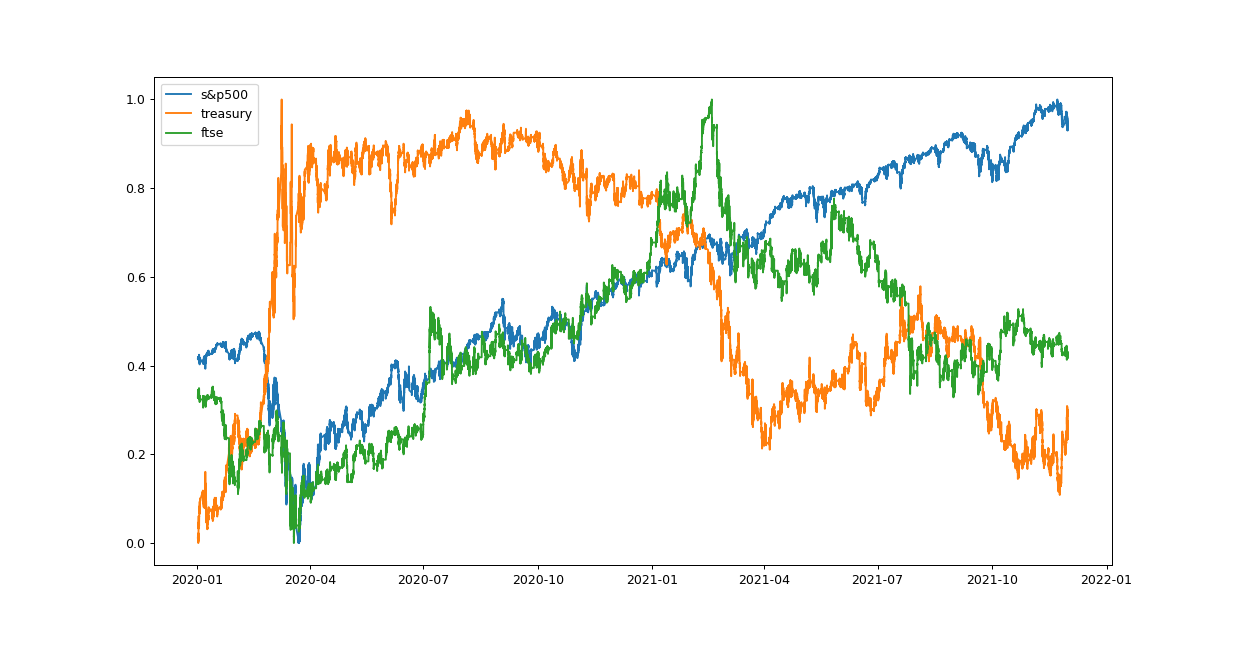

In [11]:
# plot data
plt.plot(df_norm.index, df_norm.SP500, label='s&p500')
plt.plot(df_norm.index, df_norm.Treasury, label='treasury')
plt.plot(df_norm.index, df_norm.China, label='ftse')
plt.legend()

<IPython.core.display.Javascript object>


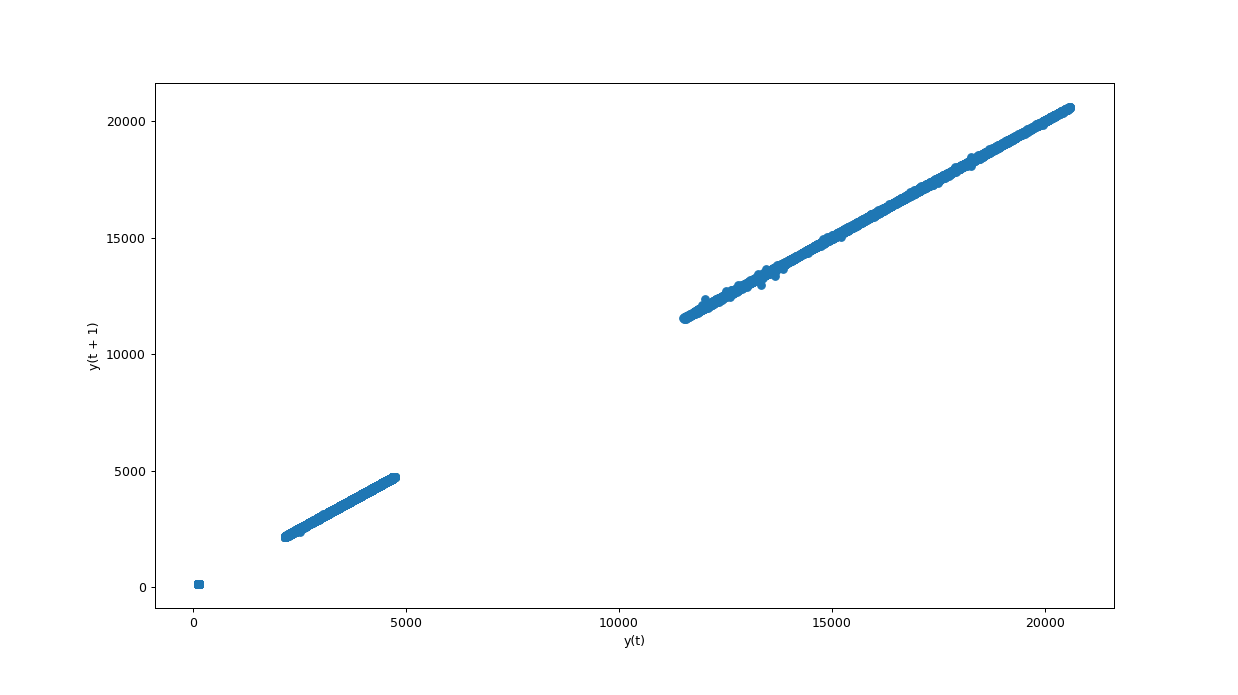

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

In [12]:
pd.plotting.lag_plot(df)

<IPython.core.display.Javascript object>


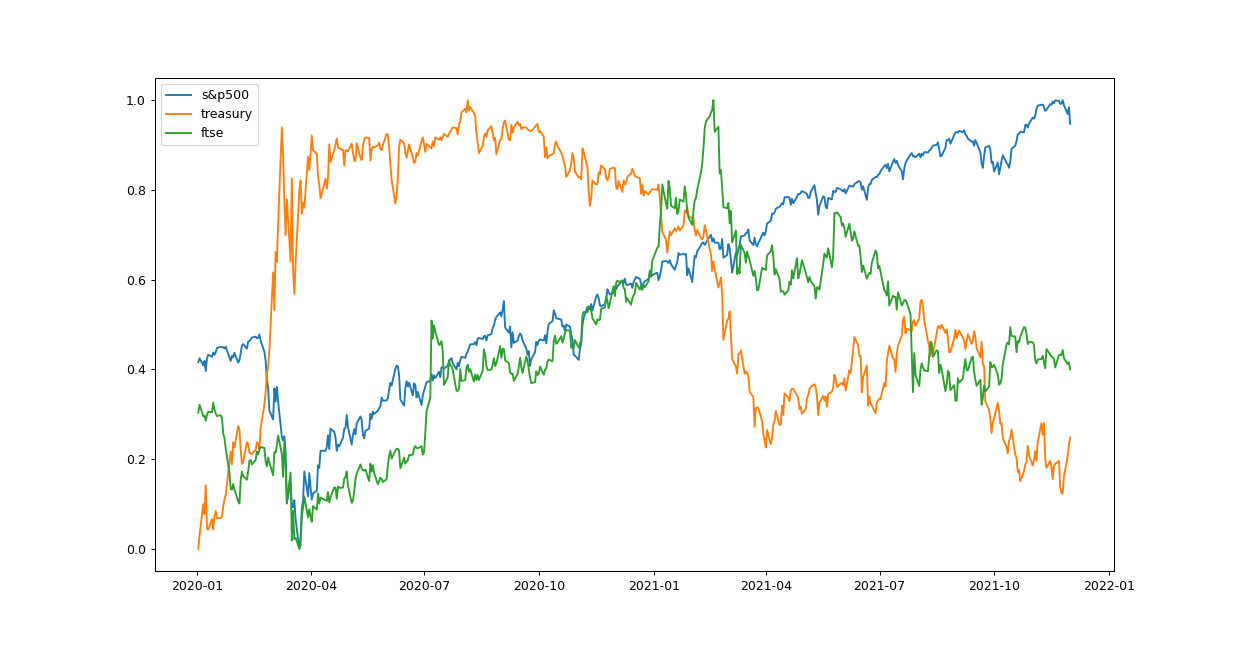

In [13]:
# to save calculation time let's look at daily data
# the same process can be adjusted on minute data
# simply do not run this cell

df = df.between_time('20:01:00', '20:01:00')
df_norm = normalize(df)
plt.plot(df_norm.index, df_norm.SP500, label='s&p500')
plt.plot(df_norm.index, df_norm.Treasury, label='treasury')
plt.plot(df_norm.index, df_norm.China, label='ftse')
plt.legend()

<IPython.core.display.Javascript object>


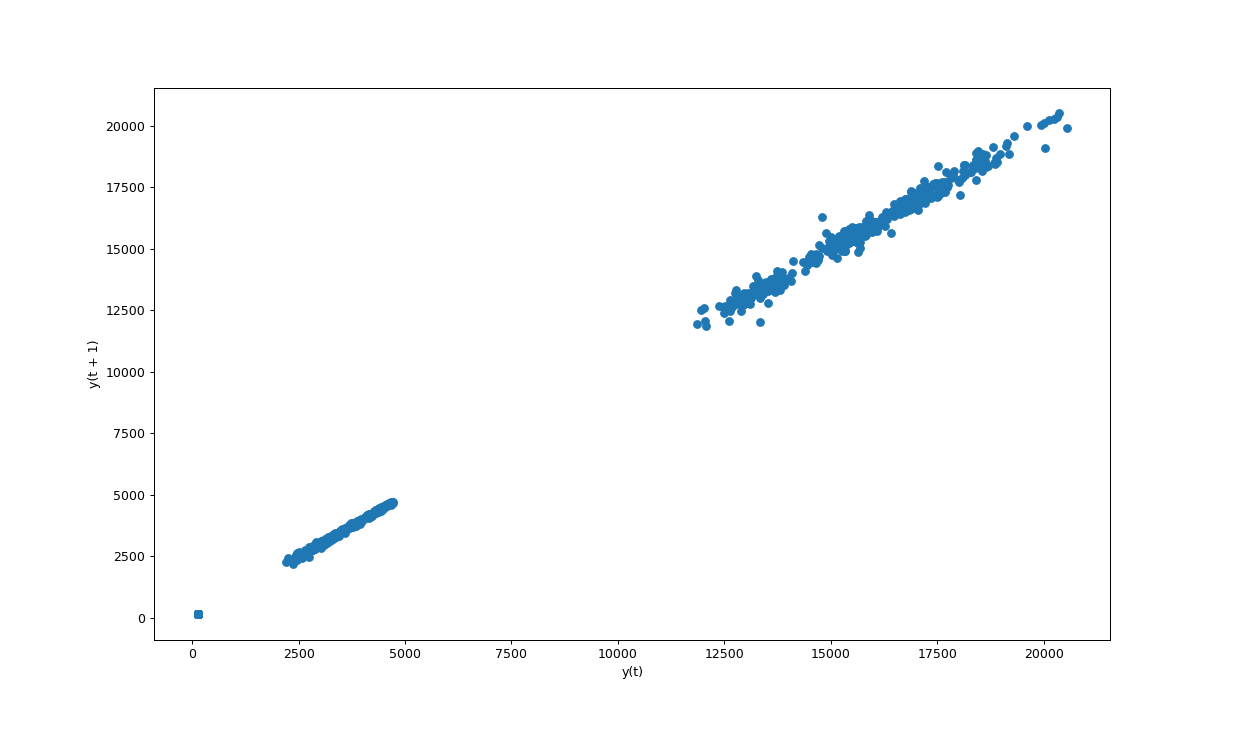

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

In [14]:
pd.plotting.lag_plot(df)

Treasury:
	Statistics = 6339.155, p = 0.0
	Kurtosis: -1.446
	Skewness: -0.199
	Data looks non-Gaussian


<IPython.core.display.Javascript object>


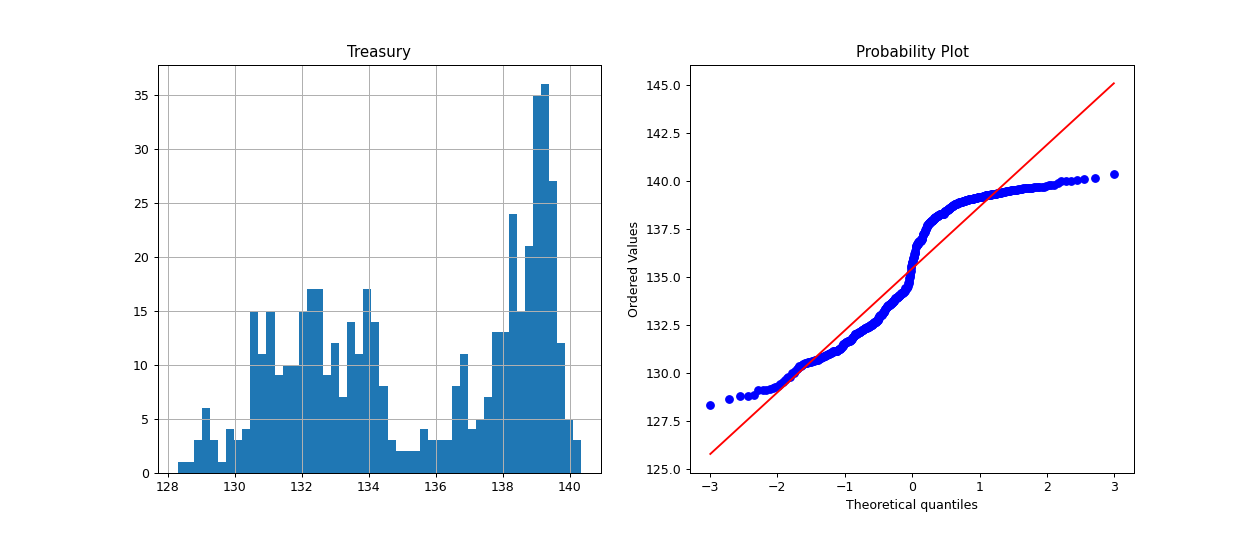

China:
	Statistics = 8.179, p = 0.017
	Kurtosis: -0.473
	Skewness: 0.097
	Data looks non-Gaussian


<IPython.core.display.Javascript object>


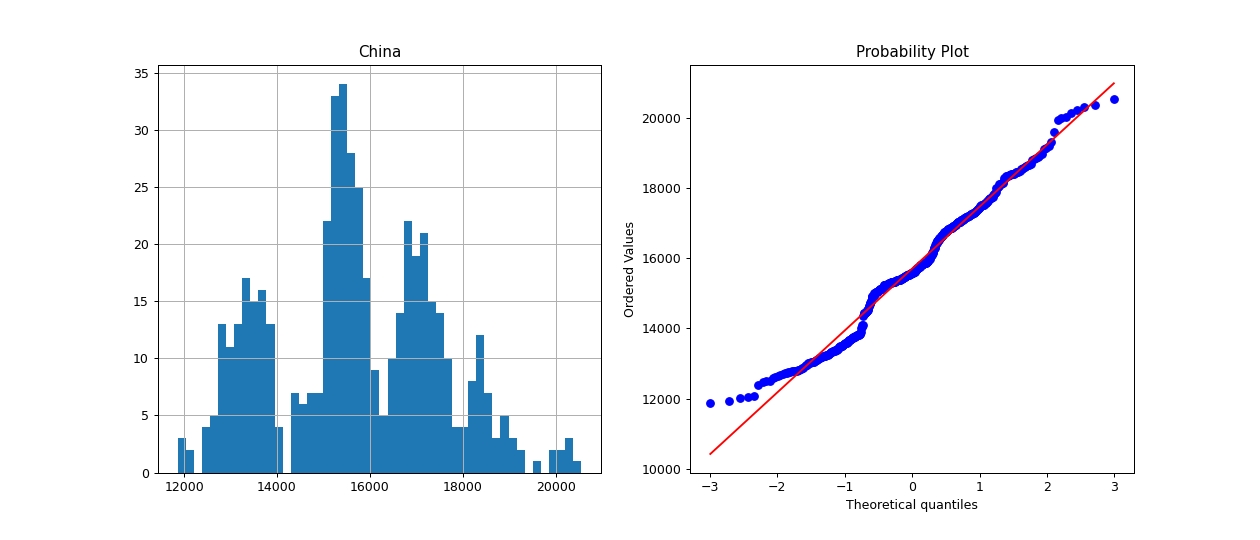

SP500:
	Statistics = 75.241, p = 0.0
	Kurtosis: -0.939
	Skewness: -0.123
	Data looks non-Gaussian


<IPython.core.display.Javascript object>


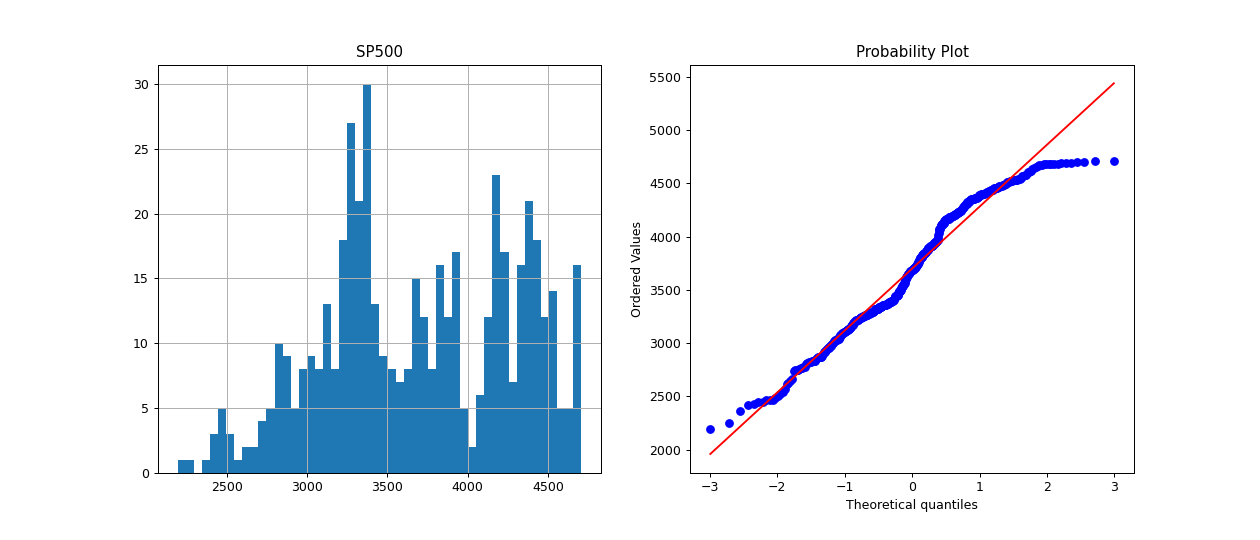

In [15]:
for col in df:
    print(f'{col}:')
    stat, p = stats.normaltest(df[col])
    print(f'\tStatistics = {round(stat, 3)}, p = {round(p, 3)}')
    print(f'\tKurtosis: {round(stats.kurtosis(df[col]), 3)}')
    print(f'\tSkewness: {round(stats.skew(df[col]), 3)}')
    if p > alpha:
        # null hypothesis
        print('\tData looks Gaussian')
    else:
        # reject null hypothesis
        print('\tData looks non-Gaussian')
    
    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    df[col].hist(bins=50)
    plt.title(col)
    plt.subplot(1,2,2)
    stats.probplot(df[col], plot=plt);
    df[col].describe().T

<IPython.core.display.Javascript object>


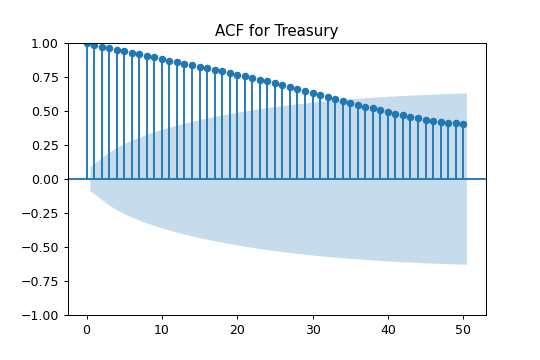

<IPython.core.display.Javascript object>


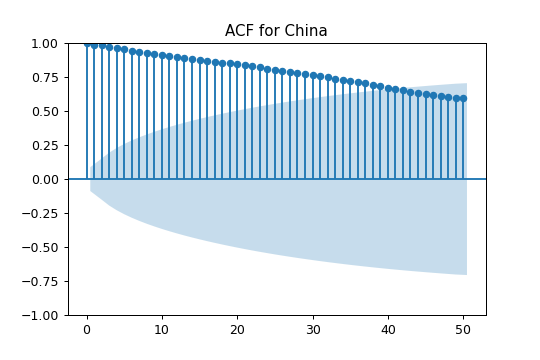

<IPython.core.display.Javascript object>


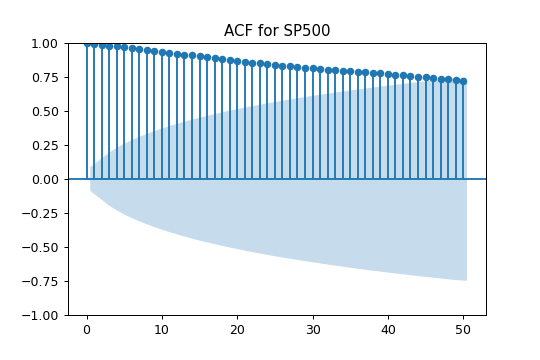

In [16]:
# plot autocorrelation
for col in df:
    plot_acf(df[col], lags=50)
    plt.title(f'ACF for {col}')

In [17]:
def cross_corr(df_x: pd.core.series.Series, 
              df_y: pd.core.series.Series, 
              lag: int=0, method: str='pearson')-> float:
    return df_x.corr(df_y.shift(lag), method=method)

<IPython.core.display.Javascript object>


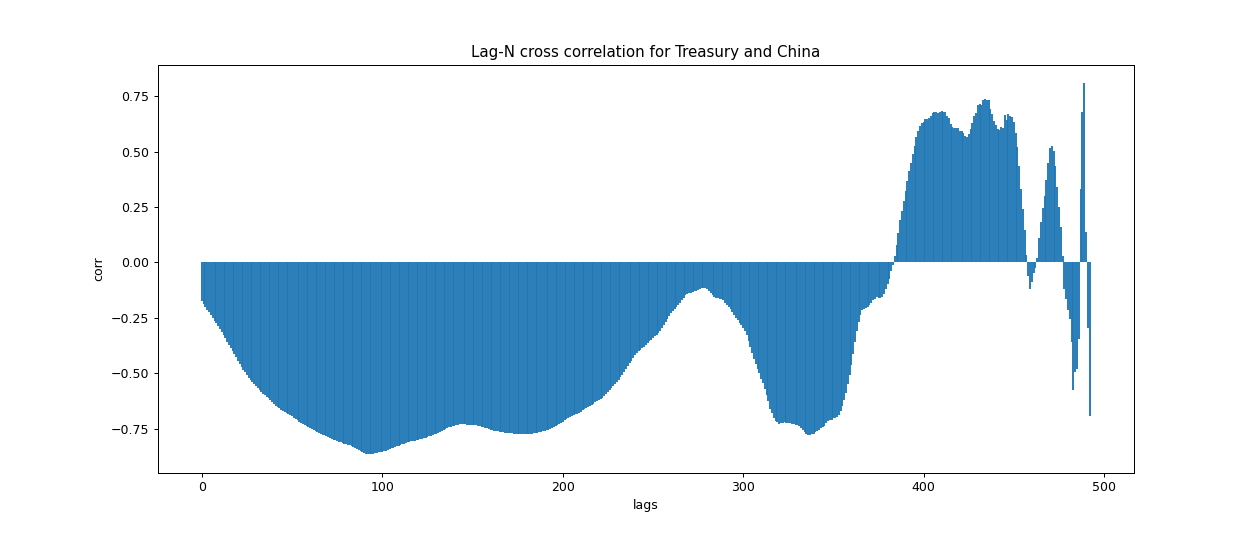

<IPython.core.display.Javascript object>


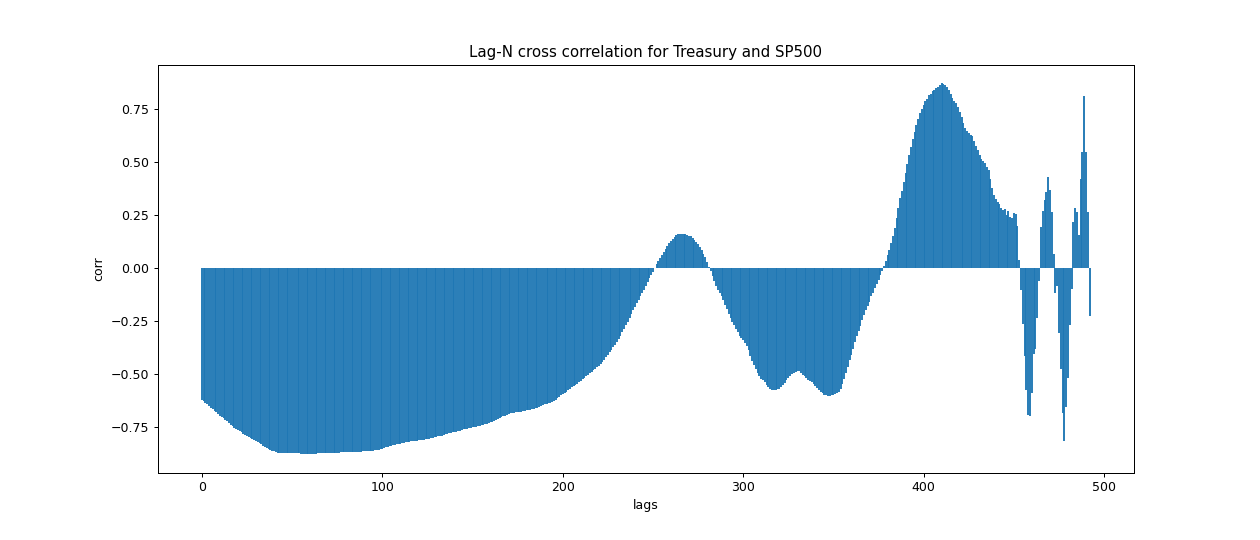

<IPython.core.display.Javascript object>


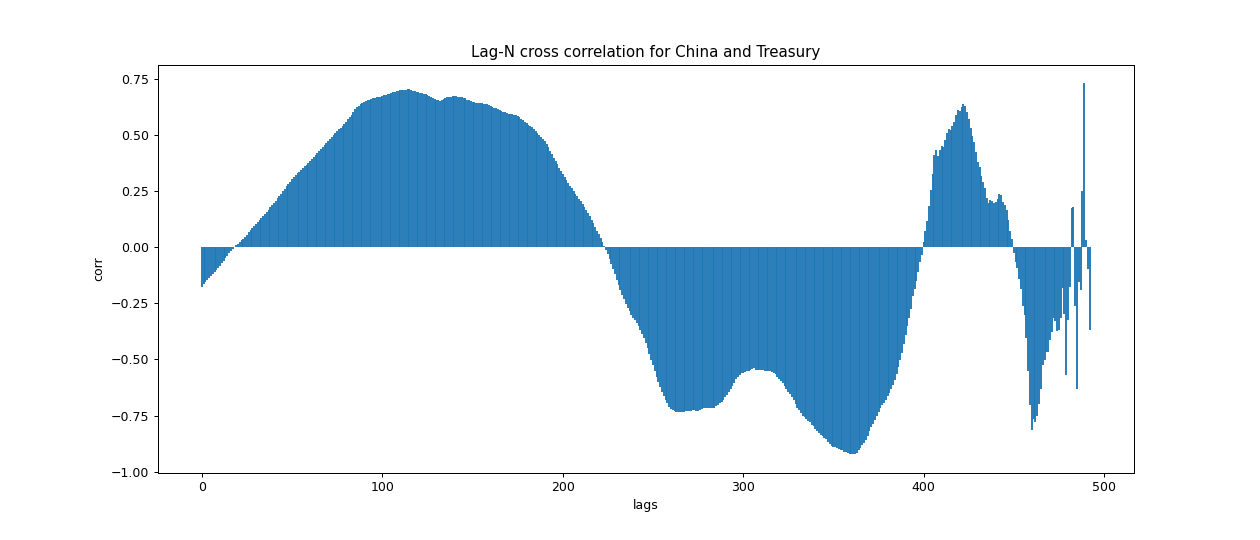

<IPython.core.display.Javascript object>


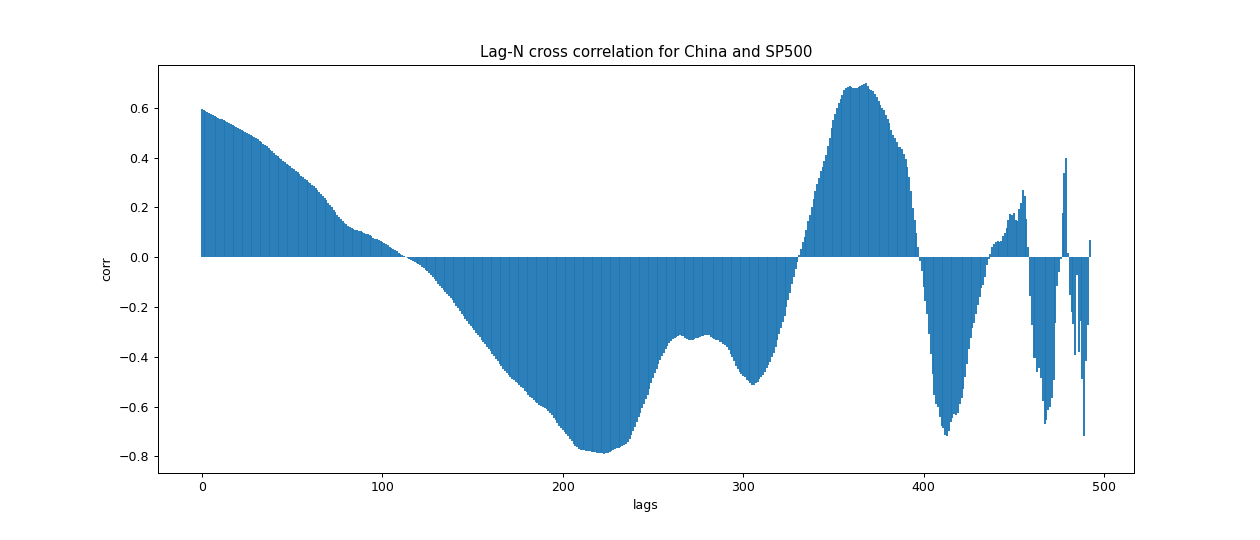

<IPython.core.display.Javascript object>


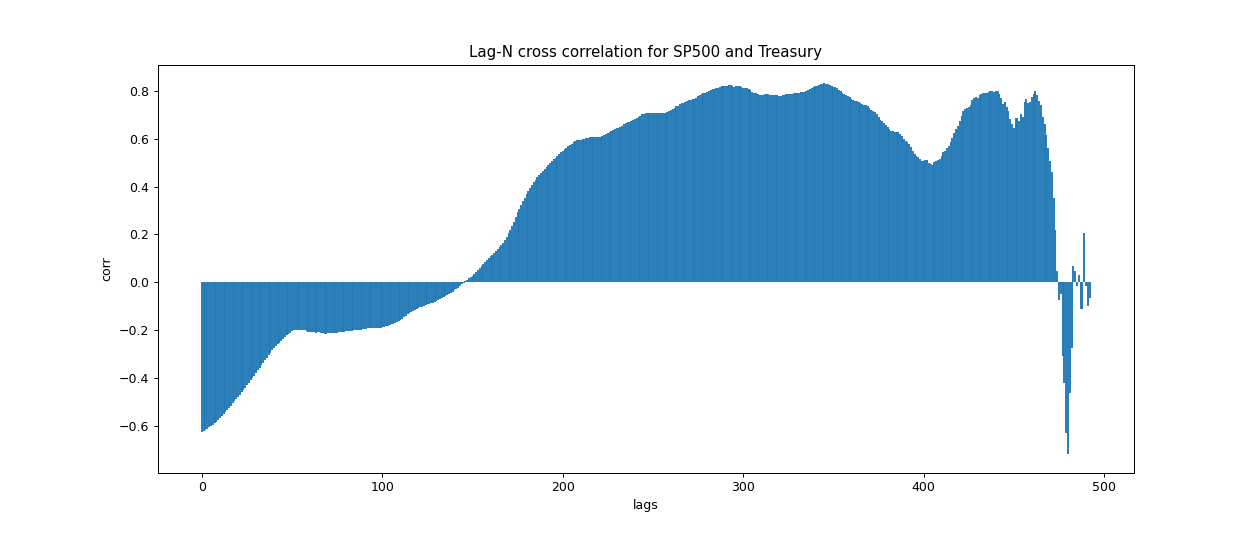

<IPython.core.display.Javascript object>


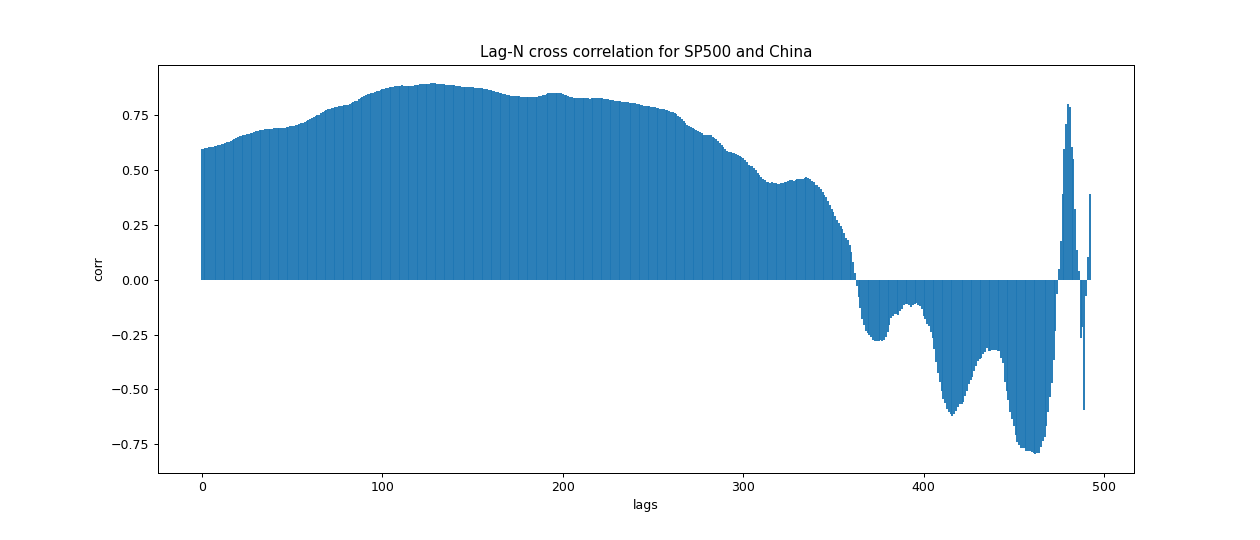

In [18]:
for col1 in df:
    for col2 in df:
        if col1 == col2:
            continue
        
        cc_val = list()
        for i in range(df.shape[0]-5):
            cc_val.append(cross_corr(df[col1], df[col2], lag=i))
   
        plt.figure(figsize=(14,6))
        plt.vlines([i for i in range(len(cc_val))], 0, cc_val)
        plt.title(f'Lag-N cross correlation for {col1} and {col2}')
        plt.xlabel('lags')
        plt.ylabel('corr')

In [22]:
# check for stationarity
def adf_stats(df: pd.DataFrame, regr: str='c', alpha: float=alpha)-> tuple:
    for col in df:
        print(f'Augmented Dickey-Fuller Test: {col} Price Time Series')
        result = adfuller(df[col].values, regression=regr)
        stat, p = result[0], result[1]

        print(f'ADF Statistic: {stat}')
        print(f'p-value: {p}')
        print('Critical Values:')
        for key, value in result[4].items():
            print(f'\t{key}: {round(value, 3)}')
        
        if p > alpha:
            # null hypothesis
            print('Data looks non-stationary\n')
        else:
            # reject null hypothesis
            print('Data looks stationary\n')

In [20]:
adf_stats(df)

Augmented Dickey-Fuller Test: Treasury Price Time Series
ADF Statistic: -1.7294072387222235
p-value: 0.4160282025481827
Critical Values:
	1%: -3.444
	5%: -2.867
	10%: -2.57
Data looks non-stationary

Augmented Dickey-Fuller Test: China Price Time Series
ADF Statistic: -1.6231395171537715
p-value: 0.4710837562109292
Critical Values:
	1%: -3.444
	5%: -2.867
	10%: -2.57
Data looks non-stationary

Augmented Dickey-Fuller Test: SP500 Price Time Series
ADF Statistic: -0.5839423242648575
p-value: 0.8745692787369321
Critical Values:
	1%: -3.444
	5%: -2.867
	10%: -2.57
Data looks non-stationary



In [9]:
# transform series
df_log = np.log(df)
df_diff =(df_log).diff().dropna()
df_diff.describe()

,Treasury,China,SP500
count,6.843150e+05,6.843150e+05,6.843150e+05
mean,3.256350e-08,8.758633e-08,5.143423e-07
std,1.092773e-04,4.055886e-04,4.387091e-04
min,-1.575199e-02,-2.697220e-02,-5.667877e-02
25%,0.000000e+00,-1.157709e-04,-1.137139e-04
50%,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,1.156069e-04,1.151410e-04
max,1.271884e-02,2.708413e-02,2.191492e-02


In [28]:
adf_stats(df_diff)
# also an extra check shows as that ADF Statistic < Critical Values so we can reject the H_0

Augmented Dickey-Fuller Test: Treasury Price Time Series
ADF Statistic: -41.44663799886661
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Data looks stationary

Augmented Dickey-Fuller Test: China Price Time Series
ADF Statistic: -30.436265099013525
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Data looks stationary

Augmented Dickey-Fuller Test: SP500 Price Time Series
ADF Statistic: -56.92027382227558
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Data looks stationary



<IPython.core.display.Javascript object>


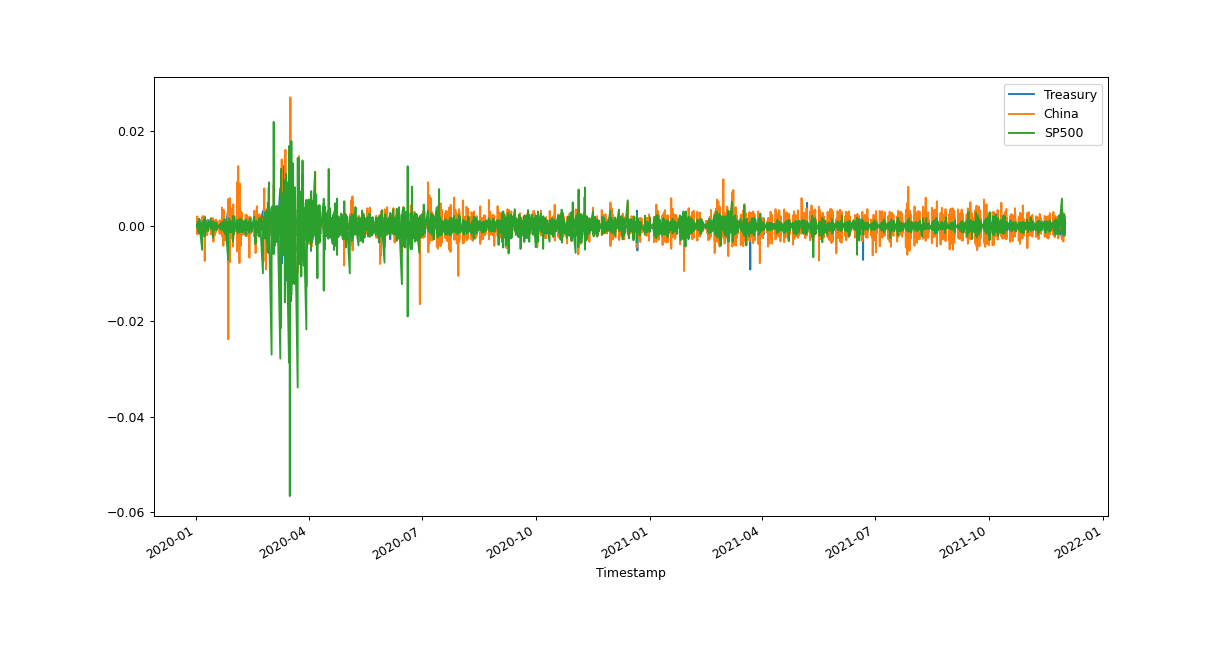

<AxesSubplot:xlabel='Timestamp'>

In [29]:
# plot transformed data
df_diff.plot()

In [10]:
# Granger causality test

def granger_caus(df: pd.DataFrame, test: str='ssr_chi2test', 
                 maxlag: int=15, verbose: bool=False, alpha: float=alpha)-> tuple:    

    df_p = pd.DataFrame(index=(df.columns+'_response'), columns=df.columns+'_predictor')
    df_lag = pd.DataFrame(index=df.columns+'_response', columns=df.columns+'_predictor')
    
    for col1 in df:
        for col2 in df:
            if col1 == col2:
                continue
            result = grangercausalitytests(df[[col1, col2]], maxlag=maxlag, verbose=verbose)
            p = [round(result[i+1][0][test][1],3) for i in range(maxlag)]
            
            df_p.loc[col1+'_response', col2+'_predictor'] = 'H1' if np.min(p) < alpha else 'H0'
            df_lag.loc[col1+'_response', col2+'_predictor'] = np.argmin(p) + 1
            
    return df_p, df_lag

print('H0 - lagged response does not explain the predictor.')
print('H1 - lagged response explain the predictor')

gc = granger_caus(df_diff[:10000])
gc[0]

H0 - lagged response does not explain the predictor.
H1 - lagged response explain the predictor


,Treasury_predictor,China_predictor,SP500_predictor
Treasury_response,NaN,H1,H1
China_response,H0,NaN,H1
SP500_response,H1,H1,NaN


In [13]:
# Johanson's cointegration test

def cointegration_test(df: pd.DataFrame, alpha: float=alpha): 
    result = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = result.lr1
    cvts = result.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df_diff[:10000])

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Treasury ::  4847.45   > 24.2761   =>   True
China  ::  3060.8    > 12.3212   =>   True
SP500  ::  1469.81   > 4.1296    =>   True
